# Exploratory Data Analysis
This notebook will explore the dataset provided for the purposes of feature engineering

In [7]:
# Import statements 
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import flesch_reading_ease, flesch_kincaid_grade
warnings.filterwarnings('ignore')

In [11]:
# Download NLTK data
def setup_nltk():
    try:
        # Try the newer punkt_tab first
        nltk.download('punkt_tab', quiet=True)
    except:
        try:
            # Fall back to older punkt
            nltk.download('punkt', quiet=True)
        except:
            print("Warning: Could not download punkt tokenizer")
    
    try:
        nltk.download('stopwords', quiet=True)
    except:
        print("Warning: Could not download stopwords")

setup_nltk()

### Fetch data from local store

In [2]:
train_data_path = "data/train_df.csv"
train_df = pd.read_csv(train_data_path)
print(train_df.head())

   Unnamed: 0                                             file_1  \
0           0  The VIRSA (Visible Infrared Survey Telescope A...   
1           1  China\nThe goal of this project involves achie...   
2           2  Scientists can learn about how galaxies form a...   
3           3  China\nThe study suggests that multiple star s...   
4           4  Dinosaur Rex was excited about his new toy set...   

                                              file_2  real_file_label  
0  The China relay network has released a signifi...                2  
1  The project aims to achieve an accuracy level ...                1  
2  Dinosaur eggshells offer clues about what dino...                2  
3  The importance for understanding how stars evo...                2  
4  Analyzing how fast stars rotate within a galax...                1  


### Construct functions to analyze data 

In [21]:
class RealVsFakeEDA:
    def __init__(self, df):
        self.df = df.copy()
        # Handle missing values in text columns
        self.df['file_1'] = self.df['file_1'].fillna('').astype(str)
        self.df['file_2'] = self.df['file_2'].fillna('').astype(str)
        
        # Create separate columns for real and fake texts
        self.df['real_text'] = self.df.apply(
            lambda row: row['file_1'] if row['real_file_label'] == 1 else row['file_2'], 
            axis=1
        )
        self.df['fake_text'] = self.df.apply(
            lambda row: row['file_2'] if row['real_file_label'] == 1 else row['file_1'], 
            axis=1
        )
        
        self.stop_words = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 
                          'from', 'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 
                          'that', 'the', 'to', 'was', 'were', 'will', 'with'}
    
    def simple_sent_tokenize(self, text):
        """Simple sentence tokenizer with null handling"""
        if pd.isna(text) or text == '':
            return []
        text = str(text)
        sentences = re.split(r'[.!?]+', text)
        return [s.strip() for s in sentences if s.strip()]
    
    def simple_word_tokenize(self, text):
        """Simple word tokenizer with null handling"""
        if pd.isna(text) or text == '':
            return []
        text = str(text)
        words = re.findall(r'\b\w+\b', text.lower())
        return words
        
    def basic_stats(self):
        """Get basic dataset statistics"""
        print("=== BASIC DATASET STATS ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print(f"Data types:\n{self.df.dtypes}")
        print(f"\nMissing values:\n{self.df.isnull().sum()}")
        
        # Check label distribution
        if 'real_file_label' in self.df.columns:
            print(f"\nLabel distribution (which file is real):")
            print(f"File 1 is real: {(self.df['real_file_label'] == 1).sum()} samples")
            print(f"File 2 is real: {(self.df['real_file_label'] == 2).sum()} samples")
        
        return self.df.describe()
    
    def text_length_analysis(self):
        """Analyze text lengths comparing real vs fake"""
        print("\n=== TEXT LENGTH ANALYSIS: REAL vs FAKE ===")
        
        # Character counts
        self.df['real_char_count'] = self.df['real_text'].str.len()
        self.df['fake_char_count'] = self.df['fake_text'].str.len()
        
        # Word counts
        self.df['real_word_count'] = self.df['real_text'].apply(lambda x: len(self.simple_word_tokenize(x)))
        self.df['fake_word_count'] = self.df['fake_text'].apply(lambda x: len(self.simple_word_tokenize(x)))
        
        # Sentence counts
        self.df['real_sent_count'] = self.df['real_text'].apply(lambda x: len(self.simple_sent_tokenize(x)))
        self.df['fake_sent_count'] = self.df['fake_text'].apply(lambda x: len(self.simple_sent_tokenize(x)))
        
        # Length differences
        self.df['char_diff'] = self.df['real_char_count'] - self.df['fake_char_count']
        self.df['word_diff'] = self.df['real_word_count'] - self.df['fake_word_count']
        self.df['sent_diff'] = self.df['real_sent_count'] - self.df['fake_sent_count']
        
        # Summary statistics
        length_stats = self.df[['real_char_count', 'fake_char_count', 'char_diff',
                               'real_word_count', 'fake_word_count', 'word_diff',
                               'real_sent_count', 'fake_sent_count', 'sent_diff']].describe()
        print(length_stats)
        
        # Key insights
        print(f"\n🔍 KEY LENGTH INSIGHTS:")
        print(f"Average real text length: {self.df['real_char_count'].mean():.0f} chars")
        print(f"Average fake text length: {self.df['fake_char_count'].mean():.0f} chars")
        print(f"Real texts are {'longer' if self.df['char_diff'].mean() > 0 else 'shorter'} by {abs(self.df['char_diff'].mean()):.0f} chars on average")
        
        print(f"\nAverage real word count: {self.df['real_word_count'].mean():.0f}")
        print(f"Average fake word count: {self.df['fake_word_count'].mean():.0f}")
        print(f"Real texts have {'more' if self.df['word_diff'].mean() > 0 else 'fewer'} words by {abs(self.df['word_diff'].mean()):.0f} on average")
        
        return length_stats
    
    def readability_analysis(self):
        """Analyze readability metrics for real vs fake"""
        print("\n=== READABILITY ANALYSIS: REAL vs FAKE ===")
        
        try:
            # Helper function to safely calculate readability
            def safe_readability(text, func):
                try:
                    if pd.isna(text) or text == '' or len(str(text).strip()) < 10:
                        return 0
                    return func(str(text))
                except:
                    return 0
            
            # Flesch Reading Ease
            self.df['real_flesch'] = self.df['real_text'].apply(lambda x: safe_readability(x, flesch_reading_ease))
            self.df['fake_flesch'] = self.df['fake_text'].apply(lambda x: safe_readability(x, flesch_reading_ease))
            
            # Flesch-Kincaid Grade
            self.df['real_fk_grade'] = self.df['real_text'].apply(lambda x: safe_readability(x, flesch_kincaid_grade))
            self.df['fake_fk_grade'] = self.df['fake_text'].apply(lambda x: safe_readability(x, flesch_kincaid_grade))
            
            # Differences
            self.df['flesch_diff'] = self.df['real_flesch'] - self.df['fake_flesch']
            self.df['fk_grade_diff'] = self.df['real_fk_grade'] - self.df['fake_fk_grade']
            
            readability_stats = self.df[['real_flesch', 'fake_flesch', 'flesch_diff',
                                       'real_fk_grade', 'fake_fk_grade', 'fk_grade_diff']].describe()
            print(readability_stats)
            
            # Key insights
            print(f"\n🔍 KEY READABILITY INSIGHTS:")
            print(f"Real texts Flesch score: {self.df['real_flesch'].mean():.1f} (higher = easier)")
            print(f"Fake texts Flesch score: {self.df['fake_flesch'].mean():.1f}")
            print(f"Real texts are {'easier' if self.df['flesch_diff'].mean() > 0 else 'harder'} to read by {abs(self.df['flesch_diff'].mean()):.1f} points")
            
            print(f"\nReal texts grade level: {self.df['real_fk_grade'].mean():.1f}")
            print(f"Fake texts grade level: {self.df['fake_fk_grade'].mean():.1f}")
            
            return readability_stats
        except Exception as e:
            print(f"Readability analysis failed: {e}")
            print("Install textstat: pip install textstat")
            return None
    
    def content_patterns(self):
        """Analyze content patterns comparing real vs fake"""
        print("\n=== CONTENT PATTERN ANALYSIS: REAL vs FAKE ===")
        
        # Numbers and measurements
        def count_numbers(text):
            if pd.isna(text) or text == '':
                return 0
            return len(re.findall(r'\d+\.?\d*', str(text)))
        
        def count_scientific_terms(text):
            if pd.isna(text) or text == '':
                return 0
            text = str(text)
            sci_terms = ['telescope', 'survey', 'observation', 'stellar', 'galaxy', 'star', 
                        'astronomical', 'magnitude', 'photometric', 'spectroscopic', 
                        'wavelength', 'redshift', 'luminosity', 'parsec', 'light-year',
                        'virsa', 'vista', 'eso', 'vlti', 'gravity', 'calibrated', 'epochs',
                        'infrared', 'visible', 'survey', 'catalog', 'dataset', 'archive']
            return sum(1 for term in sci_terms if term.lower() in text.lower())
        
        def count_technical_abbreviations(text):
            if pd.isna(text) or text == '':
                return 0
            text = str(text)
            # Common astronomy abbreviations
            abbrevs = ['ESO', 'NASA', 'VLT', 'HST', 'ALMA', 'VLA', 'JWST', 'VISTA', 'SDSS', 
                      'VIRSA', 'VMC', 'VVV', 'VIDEO', 'VIKING', 'TB', 'VLTI', 'GRAVITY',
                      'UltraVISTA', 'Phase III', 'Cycle One']
            return sum(1 for abbrev in abbrevs if abbrev in text)
        
        def count_units(text):
            if pd.isna(text) or text == '':
                return 0
            text = str(text)
            # Scientific units
            units = ['km', 'pc', 'kpc', 'Mpc', 'ly', 'AU', 'deg', 'arcmin', 'arcsec', 
                    'mag', 'nm', 'μm', 'mm', 'cm', 'TB', 'GB', 'MB', 'petabyte']
            return sum(1 for unit in units if unit in text)
        
        def count_proper_nouns(text):
            if pd.isna(text) or text == '':
                return 0
            text = str(text)
            # Look for capitalized words that aren't at sentence start
            words = text.split()
            proper_nouns = 0
            for i, word in enumerate(words):
                if word[0].isupper() and i > 0 and words[i-1][-1] not in '.!?':
                    proper_nouns += 1
            return proper_nouns
        
        # Apply content analysis to real texts
        self.df['real_numbers'] = self.df['real_text'].apply(count_numbers)
        self.df['real_sci_terms'] = self.df['real_text'].apply(count_scientific_terms)
        self.df['real_tech_abbrevs'] = self.df['real_text'].apply(count_technical_abbreviations)
        self.df['real_units'] = self.df['real_text'].apply(count_units)
        self.df['real_proper_nouns'] = self.df['real_text'].apply(count_proper_nouns)
        
        # Apply content analysis to fake texts
        self.df['fake_numbers'] = self.df['fake_text'].apply(count_numbers)
        self.df['fake_sci_terms'] = self.df['fake_text'].apply(count_scientific_terms)
        self.df['fake_tech_abbrevs'] = self.df['fake_text'].apply(count_technical_abbreviations)
        self.df['fake_units'] = self.df['fake_text'].apply(count_units)
        self.df['fake_proper_nouns'] = self.df['fake_text'].apply(count_proper_nouns)
        
        # Calculate differences
        self.df['numbers_diff'] = self.df['real_numbers'] - self.df['fake_numbers']
        self.df['sci_terms_diff'] = self.df['real_sci_terms'] - self.df['fake_sci_terms']
        self.df['tech_abbrevs_diff'] = self.df['real_tech_abbrevs'] - self.df['fake_tech_abbrevs']
        self.df['units_diff'] = self.df['real_units'] - self.df['fake_units']
        self.df['proper_nouns_diff'] = self.df['real_proper_nouns'] - self.df['fake_proper_nouns']
        
        content_stats = self.df[['real_numbers', 'fake_numbers', 'numbers_diff',
                               'real_sci_terms', 'fake_sci_terms', 'sci_terms_diff',
                               'real_tech_abbrevs', 'fake_tech_abbrevs', 'tech_abbrevs_diff',
                               'real_units', 'fake_units', 'units_diff',
                               'real_proper_nouns', 'fake_proper_nouns', 'proper_nouns_diff']].describe()
        print(content_stats)
        
        # Key insights
        print(f"\n🔍 KEY CONTENT INSIGHTS:")
        print(f"Real texts have {self.df['real_numbers'].mean():.1f} numbers vs {self.df['fake_numbers'].mean():.1f} in fake texts")
        print(f"Real texts have {self.df['real_sci_terms'].mean():.1f} scientific terms vs {self.df['fake_sci_terms'].mean():.1f} in fake texts")
        print(f"Real texts have {self.df['real_tech_abbrevs'].mean():.1f} technical abbreviations vs {self.df['fake_tech_abbrevs'].mean():.1f} in fake texts")
        print(f"Real texts have {self.df['real_units'].mean():.1f} units vs {self.df['fake_units'].mean():.1f} in fake texts")
        
        return content_stats
    
    def similarity_analysis(self):
        """Analyze similarity between real and fake text pairs"""
        print("\n=== SIMILARITY ANALYSIS: REAL vs FAKE ===")
        
        # TF-IDF similarity
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        
        # Combine all texts for fitting
        all_texts = pd.concat([self.df['real_text'], self.df['fake_text']])
        vectorizer.fit(all_texts)
        
        # Calculate similarities
        similarities = []
        for idx, row in self.df.iterrows():
            try:
                real_text = str(row['real_text']) if not pd.isna(row['real_text']) else ''
                fake_text = str(row['fake_text']) if not pd.isna(row['fake_text']) else ''
                
                if real_text == '' or fake_text == '':
                    similarities.append(0.0)
                    continue
                    
                real_vec = vectorizer.transform([real_text])
                fake_vec = vectorizer.transform([fake_text])
                sim = cosine_similarity(real_vec, fake_vec)[0][0]
                similarities.append(sim)
            except Exception as e:
                print(f"Error calculating similarity for row {idx}: {e}")
                similarities.append(0.0)
        
        self.df['real_fake_similarity'] = similarities
        
        similarity_stats = self.df['real_fake_similarity'].describe()
        print(similarity_stats)
        
        # Key insights
        print(f"\n🔍 KEY SIMILARITY INSIGHTS:")
        print(f"Average similarity between real and fake texts: {self.df['real_fake_similarity'].mean():.3f}")
        print(f"Similarity standard deviation: {self.df['real_fake_similarity'].std():.3f}")
        print(f"Minimum similarity: {self.df['real_fake_similarity'].min():.3f}")
        print(f"Maximum similarity: {self.df['real_fake_similarity'].max():.3f}")
        
        return similarity_stats
    
    def sample_analysis(self):
        """Look at actual text samples comparing real vs fake"""
        print("\n=== SAMPLE TEXT ANALYSIS: REAL vs FAKE ===")
        
        # Show examples of real vs fake
        for i in range(min(3, len(self.df))):
            sample = self.df.iloc[i]
            
            print(f"\n--- SAMPLE {i+1} ---")
            print(f"Real file was: {sample['real_file_label']}")
            print(f"Similarity score: {sample['real_fake_similarity']:.3f}")
            
            print(f"\n📍 REAL text (first 400 chars):")
            print(f"{sample['real_text'][:400]}...")
            
            print(f"\n🚫 FAKE text (first 400 chars):")
            print(f"{sample['fake_text'][:400]}...")
            
            print(f"\n📊 Quick stats:")
            print(f"Real: {len(sample['real_text'])} chars, {sample['real_word_count']} words")
            print(f"Fake: {len(sample['fake_text'])} chars, {sample['fake_word_count']} words")
    
    def feature_importance_analysis(self):
        """Analyze which features best distinguish real from fake"""
        print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
        
        # Calculate correlations with differences
        diff_features = ['char_diff', 'word_diff', 'sent_diff', 'numbers_diff', 
                        'sci_terms_diff', 'tech_abbrevs_diff', 'units_diff']
        
        if 'flesch_diff' in self.df.columns:
            diff_features.append('flesch_diff')
        
        # Show distribution of differences
        print("Distribution of Real - Fake differences:")
        print("-" * 50)
        
        for feature in diff_features:
            if feature in self.df.columns:
                mean_diff = self.df[feature].mean()
                std_diff = self.df[feature].std()
                
                print(f"{feature.replace('_', ' ').title()}: {mean_diff:.3f} ± {std_diff:.3f}")
                
                # Count how many samples favor real vs fake
                real_higher = (self.df[feature] > 0).sum()
                fake_higher = (self.df[feature] < 0).sum()
                equal = (self.df[feature] == 0).sum()
                
                print(f"  Real higher: {real_higher}/{len(self.df)} ({100*real_higher/len(self.df):.1f}%)")
                print(f"  Fake higher: {fake_higher}/{len(self.df)} ({100*fake_higher/len(self.df):.1f}%)")
                print(f"  Equal: {equal}/{len(self.df)} ({100*equal/len(self.df):.1f}%)")
                print()
    
    def visualize_patterns(self):
        """Create visualizations for real vs fake patterns"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Length comparison
        axes[0, 0].hist(self.df['real_word_count'], alpha=0.7, label='Real', bins=30, color='green')
        axes[0, 0].hist(self.df['fake_word_count'], alpha=0.7, label='Fake', bins=30, color='red')
        axes[0, 0].set_title('Word Count Distribution')
        axes[0, 0].legend()
        
        # Similarity distribution
        axes[0, 1].hist(self.df['real_fake_similarity'], bins=30, alpha=0.7, color='purple')
        axes[0, 1].set_title('Real-Fake Similarity Distribution')
        axes[0, 1].set_xlabel('Cosine Similarity')
        
        # Scientific terms comparison
        axes[0, 2].scatter(self.df['real_sci_terms'], self.df['fake_sci_terms'], alpha=0.6)
        axes[0, 2].plot([0, self.df['real_sci_terms'].max()], [0, self.df['real_sci_terms'].max()], 'r--', alpha=0.5)
        axes[0, 2].set_xlabel('Real Text Scientific Terms')
        axes[0, 2].set_ylabel('Fake Text Scientific Terms')
        axes[0, 2].set_title('Scientific Terms Comparison')
        
        # Numbers comparison
        axes[1, 0].scatter(self.df['real_numbers'], self.df['fake_numbers'], alpha=0.6)
        axes[1, 0].plot([0, self.df['real_numbers'].max()], [0, self.df['real_numbers'].max()], 'r--', alpha=0.5)
        axes[1, 0].set_xlabel('Real Text Numbers')
        axes[1, 0].set_ylabel('Fake Text Numbers')
        axes[1, 0].set_title('Numbers Comparison')
        
        # Technical abbreviations
        axes[1, 1].scatter(self.df['real_tech_abbrevs'], self.df['fake_tech_abbrevs'], alpha=0.6)
        axes[1, 1].plot([0, self.df['real_tech_abbrevs'].max()], [0, self.df['real_tech_abbrevs'].max()], 'r--', alpha=0.5)
        axes[1, 1].set_xlabel('Real Text Tech Abbreviations')
        axes[1, 1].set_ylabel('Fake Text Tech Abbreviations')
        axes[1, 1].set_title('Technical Abbreviations Comparison')
        
        # Word count differences
        axes[1, 2].hist(self.df['word_diff'], bins=30, alpha=0.7, color='orange')
        axes[1, 2].set_title('Word Count Difference (Real - Fake)')
        axes[1, 2].set_xlabel('Difference in Word Count')
        axes[1, 2].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    def run_full_analysis(self):
        """Run complete EDA pipeline focused on real vs fake"""
        print("STARTING COMPREHENSIVE REAL vs FAKE ANALYSIS")
        print("=" * 60)
        
        self.basic_stats()
        self.text_length_analysis()
        self.readability_analysis()
        self.content_patterns()
        self.similarity_analysis()
        self.feature_importance_analysis()
        self.sample_analysis()
        self.visualize_patterns()
        
        print("\nREAL vs FAKE ANALYSIS COMPLETE")
        print("=" * 60)
        print("🎯 KEY MODELING INSIGHTS:")
        print("1. Focus on features that consistently differ between real and fake")
        print("2. Look for patterns in technical content density")
        print("3. Consider similarity scores as features")
        print("4. Pay attention to length and readability differences")
        print("5. Domain-specific terms may be key discriminators")
        
        return self.df

STARTING COMPREHENSIVE REAL vs FAKE ANALYSIS
=== BASIC DATASET STATS ===
Dataset shape: (94, 10)
Columns: ['Unnamed: 0', 'file_1', 'file_2', 'real_file_label', 'file_1_char_count', 'file_2_char_count', 'file_1_word_count', 'file_2_word_count', 'real_text', 'fake_text']
Data types:
Unnamed: 0             int64
file_1                object
file_2                object
real_file_label        int64
file_1_char_count    float64
file_2_char_count    float64
file_1_word_count    float64
file_2_word_count    float64
real_text             object
fake_text             object
dtype: object

Missing values:
Unnamed: 0           0
file_1               0
file_2               0
real_file_label      0
file_1_char_count    1
file_2_char_count    1
file_1_word_count    1
file_2_word_count    1
real_text            0
fake_text            0
dtype: int64

Label distribution (which file is real):
File 1 is real: 50 samples
File 2 is real: 44 samples

=== TEXT LENGTH ANALYSIS: REAL vs FAKE ===
       real_ch

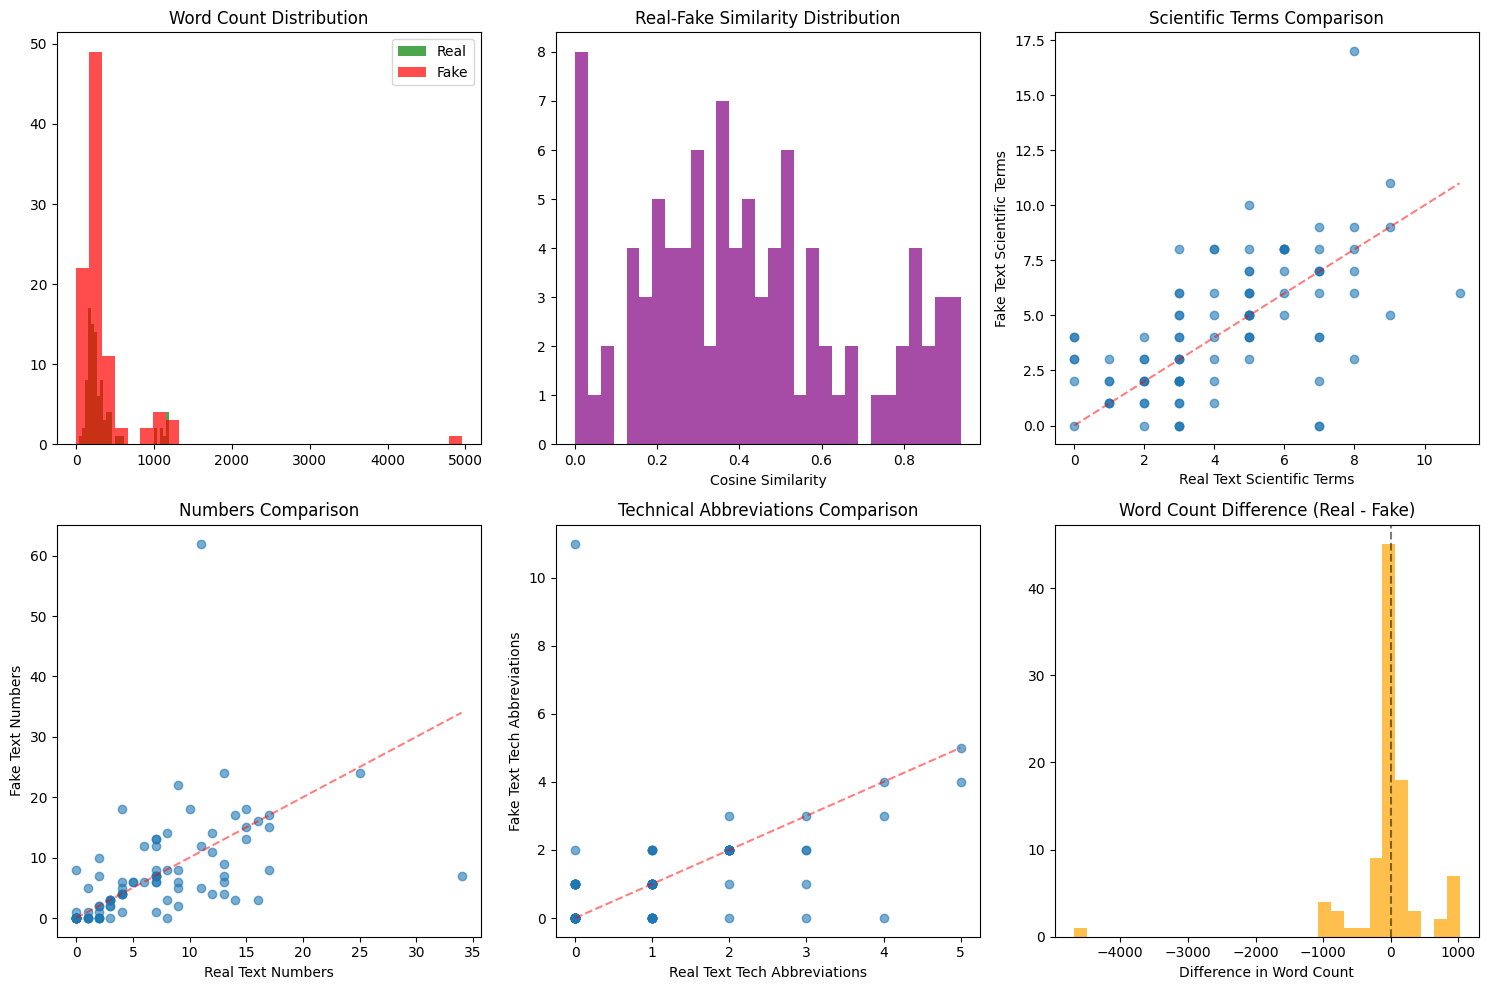


REAL vs FAKE ANALYSIS COMPLETE
🎯 KEY MODELING INSIGHTS:
1. Focus on features that consistently differ between real and fake
2. Look for patterns in technical content density
3. Consider similarity scores as features
4. Pay attention to length and readability differences
5. Domain-specific terms may be key discriminators


In [22]:
eda = RealVsFakeEDA(train_df)
analyzed_df = eda.run_full_analysis()